# How can we predict the value of the S&P 500?
Jasper Hsu, Thomas Suman, Trey Hensel

## Libraries and dependencies:

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import math
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime

## Loading the data: 
https://www.kaggle.com/datasets/gkitchen/s-and-p-500-spy

In [85]:
df = pd.read_csv("spy.csv")

First, we must decide what we are trying to predict. Our dataset supplies us with four options: open, high, low, and close. Predicting the high and low values of the stock on a given day is a seemingly good idea, but this information is hard to use because it is also dependent on time - and we aren't given any data on when the stock hits either extremity. Predicting the value of the stock when the market opens is definitely useful, but it generally doesn't reflect the overall market sentiment and may be heavily influenced by unpredictable overnight news or events. On the other hand, the closing price of a stock reflects the overall market sentiment and demand for the stock at the end of the trading day. It is also widely used as a benchmark for measuring the performance of the stock market. Thus, we will be predicting the closing price.

## Test/train split:

In [146]:
df = df.sample(frac = 1)
train_proportion = 0.8
n = len(df)
split = math.floor(n*train_proportion)

def times_to_timestamps(time_arr):
    # Define a function to convert a single time string to a timestamp
    def time_to_timestamp(time_str):
        time_obj = datetime.strptime(time_str, '%Y-%m-%d')
        timestamp = int(time_obj.timestamp())
        return timestamp
    
    # Use the vectorize function to apply the time_to_timestamp function to every element in the array
    timestamp_arr = np.vectorize(time_to_timestamp)(time_arr)
    
    # Return the resulting array of timestamps
    return timestamp_arr

target = df["Close"]
data = pd.DataFrame(np.array(times_to_timestamps(df["Date"]))/(10**8))

# the following variable records the features of examples in the training set
train_x = data.iloc[:split]
# the following variable records the features of examples in the test set
test_x = data.iloc[split+1:]
# the following variable records the labels of examples in the training set
train_y = target[:split]
# the following variable records the labels of examples in the test set
test_y = target[split+1:]


Note that we converted string data from the "Date" column formatted as "YYYY-MM-DD" to integers, and we are trying to use the "Date" feature to predict the our target "Close" value.

## Attempt #1: Linear Regression Model

Train MSE	 2756.119640261356
Test MSE	 2904.9991351646327


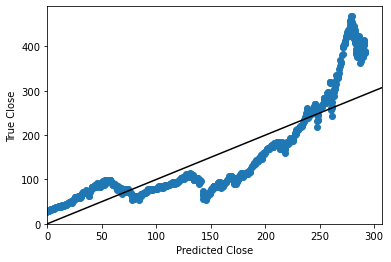

x1        32.885307
const   -260.555374
dtype: float64


In [147]:
# This function just computes the mean squared error
def MSE(y, pred):
    return np.mean(np.square(np.subtract(y, pred)))

# This function plots the main diagonal;for a "predicted vs true" plot with perfect predictions, all data lies on this line
def plotDiagonal(xmin, xmax):
    xsamples = np.arange(xmin,xmax,step=0.01)
    plt.plot(xsamples,xsamples,c='black')

# This helper function plots x vs y and labels the axes
def plotdata(x=None,y=None,xname=None,yname=None,margin=0.05,plotDiag=True,zeromin=False):
    plt.scatter(x,y,label='data')
    plt.xlabel(xname)
    plt.ylabel(yname)
    range_x = max(x) - min(x)
    range_y = max(y) - min(y)
    if plotDiag:
        plotDiagonal(min(x)-margin*range_x,max(x)+margin*range_x)
    if zeromin:
        plt.xlim(0.0,max(x)+margin*range_x)
        plt.ylim(0.0,max(y)+margin*range_y)
    else:
        plt.xlim(min(x)-margin*range_x,max(x)+margin*range_x)
        plt.ylim(min(y)-margin*range_y,max(y)+margin*range_y)
    plt.show()

# This function plots the predicted labels vs the actual labels (We only plot the first 1000 points to avoid slow plots)
def plot_pred_true(test_pred=None, test_y=None, max_points = 1000):
    plotdata(test_pred[1:max_points], test_y[1:max_points],'Predicted Close', 'True Close', zeromin=True)

# This function runs OLS and bypasses any SVD (Singular Value Decomposition) convergence errors by refitting the model
def run_OLS(train_y, test_y, train_vals, test_vals):
    ols_model = sm.regression.linear_model.OLS(train_y, train_vals)
    while True: # Bypasses SVD convergence assertion error
        try:
            results = ols_model.fit()
            break
        except:
            None
            
    w = np.array(results.params).reshape([len(results.params),1])

    train_pred = np.matmul(train_vals,w)
    test_pred = np.matmul(test_vals,w)

    train_MSE = MSE(train_y, train_pred.flatten())
    test_MSE = MSE(test_y, test_pred.flatten())
    
    return train_MSE, test_MSE, test_pred, results

train_vals_offset = np.ones(train_x.shape[0]).reshape(-1, 1)
train_vals = np.concatenate([train_x, train_vals_offset], axis=1)

test_vals_offset = np.ones(test_x.shape[0]).reshape(-1, 1)
test_vals = np.concatenate([test_x, test_vals_offset], axis=1)

train_MSE, test_MSE, test_pred, result = run_OLS(train_y, test_y, train_vals, test_vals)

print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))

plot_pred_true(test_pred.flatten(), test_y)

print(result.params)

## Attempt #2 Quantile Loss

Train MSE	 3542.2572423557594
Test MSE	 3884.462426666418


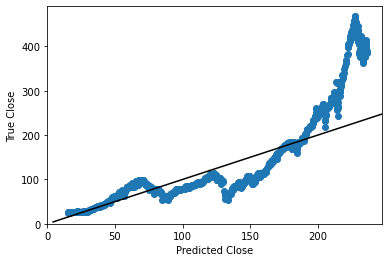

x1        23.295299
const   -154.568694
dtype: float64


In [148]:
def run_quant(train_y, test_y, train_vals, test_vals):
    quant_model = sm.regression.quantile_regression.QuantReg(train_y, train_vals)
    while True: # Bypasses SVD convergence assertion error
        try:
            results = quant_model.fit()
            break
        except:
            None

    w = np.array(results.params).reshape([len(results.params),1])

    train_pred = np.matmul(train_vals,w)
    test_pred = np.matmul(test_vals,w)

    train_MSE = MSE(train_y, train_pred.flatten())
    test_MSE = MSE(test_y, test_pred.flatten())
    
    return train_MSE, test_MSE, test_pred, results

train_MSE, test_MSE, test_pred, result = run_quant(train_y, test_y, train_vals, test_vals)

print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))

plot_pred_true(test_pred.flatten(), test_y)

print(result.params)

## Attempt #3 Huber Loss

Train MSE	 3078.04956375758
Test MSE	 3358.4842868957103


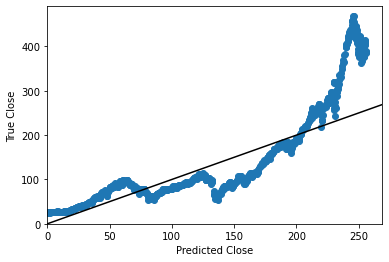

[ 2.69453076e+01 -8.01041740e-05]
-196.39143979469716


In [149]:
from sklearn.linear_model import HuberRegressor

def run_huber(train_y, test_y, train_vals, test_vals, alpha=1.0):
    # Create Ridge regression object with desired alpha value
    huber_model = HuberRegressor(alpha=alpha)
    
    # Fit the Ridge regression model to the training data
    result = huber_model.fit(train_vals, train_y)
    
    # Predict on the training and test sets
    train_pred = huber_model.predict(train_vals)
    test_pred = huber_model.predict(test_vals)
    
    # Calculate the mean squared error on the training and test sets
    train_MSE = MSE(train_y, train_pred.flatten())
    test_MSE = MSE(test_y, test_pred.flatten())
    
    return train_MSE, test_MSE, test_pred, result

train_MSE, test_MSE, test_pred, result = run_huber(train_y, test_y, train_vals, test_vals)

print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))

plot_pred_true(test_pred.flatten(), test_y)

print(result.coef_)
print(result.intercept_)

## Attempt #4 Ridge Regression

Train MSE	 2756.1196441694187
Test MSE	 2905.0067653914984


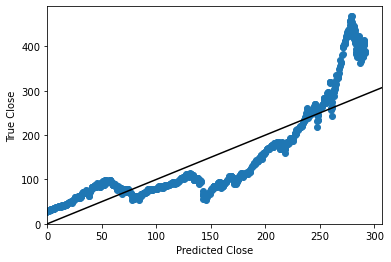

[32.88458469  0.        ]
-260.5466482267912


In [150]:
from sklearn.linear_model import Ridge

def run_ridge(train_y, test_y, train_vals, test_vals, alpha=1.0):
    # Create Ridge regression object with desired alpha value
    ridge_model = Ridge(alpha=alpha)
    
    # Fit the Ridge regression model to the training data
    result = ridge_model.fit(train_vals, train_y)
    
    # Predict on the training and test sets
    train_pred = ridge_model.predict(train_vals)
    test_pred = ridge_model.predict(test_vals)
    
    # Calculate the mean squared error on the training and test sets
    train_MSE = MSE(train_y, train_pred.flatten())
    test_MSE = MSE(test_y, test_pred.flatten())
    
    return train_MSE, test_MSE, test_pred, result

train_MSE, test_MSE, test_pred, result = run_ridge(train_y, test_y, train_vals, test_vals)

print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))

plot_pred_true(test_pred.flatten(), test_y)


print(result.coef_)
print(result.intercept_)

## Attempt #5 Feature Engineeering w/ Added Features and OLS

Train MSE	 2767.379167362565
Test MSE	 2874.2535069708442


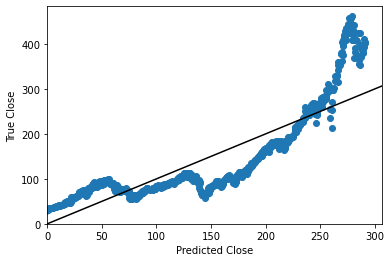

x1        33.036213
x2        -0.013102
x3         0.000488
const   -261.005458
dtype: float64


In [151]:
df2 = pd.read_csv("spy.csv")
df_fe = df2[1:].reset_index(drop=True)
df_fe = df_fe.sample(frac = 1)
df_fe['Previous Close'] = df2['Close'][:-1]
df_fe['Previous Volume'] = df2['Volume'][:-1]/(10**5)
df_fe['High - Low'] = df2['High'][:-1]-df2['Low'][:-1]

train_proportion = 0.8
n = len(df_fe)
split = math.floor(n*train_proportion)

target_fe = df_fe["Close"]
data_fe = pd.DataFrame({'Time': np.array(times_to_timestamps(df_fe["Date"]))/(10**8)})
data_fe = data_fe.join(df_fe[['Previous Close', 'Previous Volume']])

# the following variable records the features of examples in the training set
train_x_fe = data_fe.iloc[:split]
# the following variable records the features of examples in the test set
test_x_fe = data_fe.iloc[split+1:]
# the following variable records the labels of examples in the training set
train_y_fe = target_fe[:split]
# the following variable records the labels of examples in the test set
test_y_fe = target_fe[split+1:]

train_vals_offset_fe = np.ones(train_x_fe.shape[0]).reshape(-1, 1)
train_vals_fe = np.concatenate([train_x_fe, train_vals_offset_fe], axis=1)

test_vals_offset_fe = np.ones(test_x_fe.shape[0]).reshape(-1, 1)
test_vals_fe = np.concatenate([test_x_fe, test_vals_offset_fe], axis=1)


train_MSE, test_MSE, test_pred, result = run_OLS(train_y_fe, test_y_fe, train_vals_fe, test_vals_fe)

print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))

plot_pred_true(test_pred.flatten(), test_y_fe)

print(result.params)

## Attempt #6 Feature Engineering w/ Log Manipulation and OLS

Train MSE	 1581.5297248805555
Test MSE	 1615.7559178404413


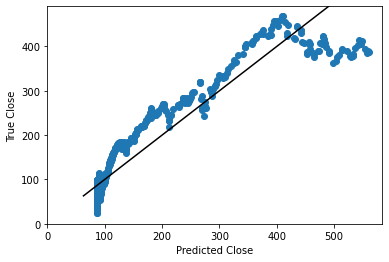

x1        0.000024
const    86.613172
dtype: float64


In [152]:
target1 = df["Close"]
data1 = pd.DataFrame(np.exp(np.array(times_to_timestamps(df["Date"]))/(10**8)))

# the following variable records the features of examples in the training set
train_x1 = data1.iloc[:split]
# the following variable records the features of examples in the test set
test_x1 = data1.iloc[split+1:]
# the following variable records the labels of examples in the training set
train_y1 = target1[:split]
# the following variable records the labels of examples in the test set
test_y1 = target1[split+1:]

train_vals_offset1 = np.ones(train_x1.shape[0]).reshape(-1, 1)
train_vals1 = np.concatenate([train_x1, train_vals_offset1], axis=1)

test_vals_offset1 = np.ones(test_x1.shape[0]).reshape(-1, 1)
test_vals1 = np.concatenate([test_x1, test_vals_offset1], axis=1)

train_MSE, test_MSE, test_pred, result = run_OLS(train_y1, test_y1, train_vals1, test_vals1)

print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))

plot_pred_true(test_pred.flatten(), test_y1)


print(result.params)

## Attempt #7 Kernel Ridge Regression

Train MSE	 301.75842488874025
Test MSE	 297.48335686069225


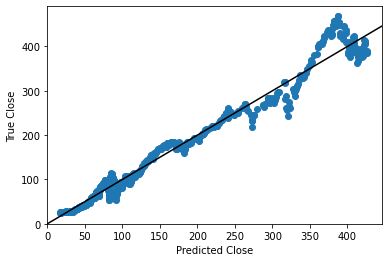

[ -5.86535269  -8.79488159 -15.87351442 ...  -3.85215293 -29.16698604
  -4.80233727]


In [154]:
from sklearn.kernel_ridge import KernelRidge

def run_kernel_regression(train_y, test_y, train_vals, test_vals, kernel='rbf', gamma=0.1):
    # Create kernel regression object
    kr = KernelRidge(kernel=kernel, gamma=gamma)

    # Fit the model to the training data
    result = kr.fit(train_vals, train_y)

    # Make predictions on the training and test data
    train_pred = kr.predict(train_vals)
    test_pred = kr.predict(test_vals)

    # Calculate the mean squared error on the training and test data
    train_MSE = MSE(train_y, train_pred.flatten())
    test_MSE = MSE(test_y, test_pred.flatten())

    return train_MSE, test_MSE, test_pred, result

train_MSE, test_MSE, test_pred, result = run_kernel_regression(train_y, test_y, train_vals, test_vals)

print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))

plot_pred_true(test_pred.flatten(), test_y)

print(result.dual_coef_)

## Linear Classification w/ Perceptron

Accuracy: 0.5470704410796576
            Open  YesterdayClose  YesterdayVolume
0      25.140206       25.122355          1003200
1      25.283158       25.301018           480500
2      25.390361       25.354630           201300
3      25.711994       25.622644           529400
4      25.711988       25.729862           531500
...          ...             ...              ...
7592  398.119995      395.750000        107682400
7593  395.769989      396.489990         74010400
7594  399.929993      395.600006         62871700
7595  404.089996      401.350006         77497900
7596  404.660004      403.700012         69840000

[7597 rows x 3 columns]


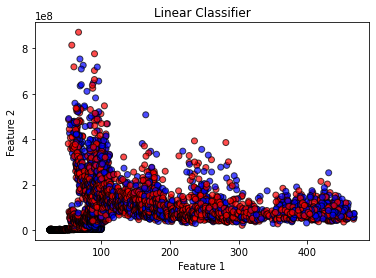

In [156]:
df = pd.read_csv("spy.csv")
df1 = df[1:].reset_index(drop = True)
dayBefore = df['Close'][:-1]
today = df[1:].reset_index()['Close']
df1['Up'] = (today > dayBefore).astype(int)
df1['YesterdayClose'] = df['Close'][:-1]
df1['YesterdayVolume'] = df['Volume'][:-1]
df1.head()
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


train_proportion = 0.8
n = len(df1)
split = math.floor(n*train_proportion)

target = df1["Up"]
features = ["Open", "YesterdayClose", "YesterdayVolume"]
data = df1.loc[:, df1.columns.isin(features)]

# the following variable records the features of examples in the training set
X_train = data.iloc[:split]
# the following variable records the features of examples in the test set
X_test = data.iloc[split+1:]
# the following variable records the labels of examples in the training set
y_train = target[:split]
# the following variable records the labels of examples in the test set
y_test = target[split+1:]

# Create a logistic regression classifier
classifier = LogisticRegression()

# Train the classifier on the training data
classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = classifier.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

X = df1[features]
print(X)
# print(X[:, 0])
plt.scatter(X['YesterdayClose'], X['YesterdayVolume'], c=target, cmap='bwr', alpha=0.7, edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Linear Classifier')
plt.show()